# DATA PREPARATION 

In [1]:
#INGESTING CRITICS DATA FILE INTO CRITICS
import boto3
import pandas as pd
s3_client = boto3.client("s3")
BUCKET='ecinemas'
KEY='cx/cx.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
cx = pd.read_csv(response.get("Body"))
cx.head()

,ID_Movie,Expert,Score,Sentiment,Review
0,7369,RogerEbert.com,88,3,Call Me Lucky will be an especially grueling r...
1,7369,New York Daily News,80,1,"Angry, quixotic, tragic, heroic — Crimmins’ li..."
2,7369,Village Voice,80,7,Call Me Lucky is a loving but fair portrait of...
3,7369,TheWrap,75,2,There should be more Crimmins performance foot...
4,7369,Movie Nation,75,3,Call Me Lucky is another of those “the funnies...


In [2]:
#INGESTING USERS DATA FILE INTO USER
BUCKET='ecinemas'
KEY='user/user.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
user = pd.read_csv(response.get("Body"))
user.head()

,ID_Movie,Score,Sentiment,User,Review
0,1,7,12,DemiRonin,$9.99 is a series of unique short stories. How...
1,1,4,2,steven,I don't mean to be a Debbie Downer and I am al...
2,3,9,0,RayJ.,Superb.
3,3,9,0,MichaelV.,Lillo is so hot!
4,3,6,-4,GilbertMulroneycakesAndFriends,What the hell is that title all about? I assum...


In [3]:
#INGESTING SALE DATA TABLE INTO SALE
s3_client = boto3.client("s3")
BUCKET='ecinemas'
KEY='sale/sale.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
sale = pd.read_csv(response.get("Body"))
sale.head()

,MovieName,Rank_data,PreviousWeekRank,GrossW,Theaters
0,Stuart Little,1,1,13012299,2979
1,The Green Mile,2,3,12521303,2678
2,The Talented Mr. Ripley,3,2,11780319,2316
3,Any Given Sunday,4,4,10971011,2505
4,Galaxy Quest,5,6,9784389,2450


In [4]:
#INGESTING PRODUCT DATA TABLE IN PRODUCT
BUCKET='ecinemas'
KEY='product/product.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
product = pd.read_csv(response.get("Body"))
product.head()

,ID,Title,Publisher,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Runtime,Genre,Rating
0,1,9.99,Regent Releasing,68.0,12.0,3.0,0.0,7.1,1,1.0,0,78 min,Drama;Animation,Rated R for language and brief sexuality and n...
1,2,$pent,Regent Releasing,34.0,1.0,3.0,4.0,0.0,0,0.0,0,91 min,Genre: ...,NaN
2,3,'R Xmas,Pathfinder Pictures,55.0,4.0,5.0,2.0,7.1,4,0.0,0,85 min,Drama;Crime,"Rated R for strong language, drug content and ..."
3,4,(500) Days of Summer,Fox Searchlight Pictures,76.0,33.0,3.0,0.0,7.9,161,7.0,24,95 min,Drama;Comedy;Romance,Rated PG-13 for sexual material and language.
4,5,1,IFC Midnight,60.0,3.0,2.0,1.0,8.0,0,0.0,0,NaN,NULL,NaN


In [9]:
#DROPPING UNNECESSARY COLUMNS FROM PRODUCT DATASET

product = product.drop(columns =['ID','Publisher'], axis=True)
product.head()


,Title,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Runtime,Genre,Rating
0,9.99,68.0,12.0,3.0,0.0,7.1,1,1.0,0,78 min,Drama;Animation,Rated R for language and brief sexuality and n...
1,$pent,34.0,1.0,3.0,4.0,0.0,0,0.0,0,91 min,Genre: ...,NaN
2,'R Xmas,55.0,4.0,5.0,2.0,7.1,4,0.0,0,85 min,Drama;Crime,"Rated R for strong language, drug content and ..."
3,(500) Days of Summer,76.0,33.0,3.0,0.0,7.9,161,7.0,24,95 min,Drama;Comedy;Romance,Rated PG-13 for sexual material and language.
4,1,60.0,3.0,2.0,1.0,8.0,0,0.0,0,NaN,NULL,NaN


# FEATURE TRANSFORMATION

#1) SALE_GROUPED TABLE AND PRODUCT ARE TWO USEFUL DATASET FOR THE PROJECT. THUS, THESE TWO TABLES WILL BE MERGED BY MOVIENAMES.

#2) The weekly gross sales were averaged as Avg_GrossW by grouping with each specific movie name to represent the average gross sales for each movie from the sale table.

#3) Split Runtime (Object variable) into numerical variable (For example, 100min into 100) after filling the NaN values with approximate runtime 100min to preserve the numbers of records.

#4) Change original variables into float varialbles for '[User_Score', 'User_Pos_Count', 'User_Neg_Count'] for filling the missing values with Median values to preserve the numbers of records.

#5) Origina 'Rating' column was in text format with Rated, PG, PG-13, etc information. First we create dummy categorical varialbes by extraintg out words such as PG, PG-13, Rated from the text column. After that, we assign the numerical varialbes and saved under 'Rated' column.

In [11]:
# Since GrossW is for weekly gross sale for each movie, grouping the MovieName with Average GrossW values

sale_grouped = sale.groupby(['MovieName'])\
.agg( Avg_GrossW = ('GrossW', 'mean'))
sale_grouped.head()

,Avg_GrossW
MovieName,
!Women Art Revolution,3762.928571
$9.99,3081.411765
'71,127084.700000
'85: The Greatest Team in Football History,62286.500000
'Tis Autumn: The Search for Jackie Paris,1476.000000


In [12]:
#CHANGE TITLE FROM PRODUCT AS MOVIENAME FOR MERGING TWO TABLES
product = product.rename(columns={'Title':'MovieName'})
product.head()

,MovieName,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Runtime,Genre,Rating
0,9.99,68.0,12.0,3.0,0.0,7.1,1,1.0,0,78 min,Drama;Animation,Rated R for language and brief sexuality and n...
1,$pent,34.0,1.0,3.0,4.0,0.0,0,0.0,0,91 min,Genre: ...,NaN
2,'R Xmas,55.0,4.0,5.0,2.0,7.1,4,0.0,0,85 min,Drama;Crime,"Rated R for strong language, drug content and ..."
3,(500) Days of Summer,76.0,33.0,3.0,0.0,7.9,161,7.0,24,95 min,Drama;Comedy;Romance,Rated PG-13 for sexual material and language.
4,1,60.0,3.0,2.0,1.0,8.0,0,0.0,0,NaN,NULL,NaN


In [13]:
#MERGING SALE AND PRODUCT DATASET AS MOVIE DATASET
movie = pd.merge(sale_grouped,product, on='MovieName')
movie.head()

,MovieName,Avg_GrossW,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Runtime,Genre,Rating
0,'71,1.270847e+05,83.0,32.0,2.0,0.0,7.5,119,2.0,6,99 min,"Action,Drama,Thriller,War",R
1,...So Goes the Nation,1.476714e+03,65.0,9.0,3.0,0.0,0.0,1,0.0,0,NaN,NULL,NaN
2,"1,000 Times Good Night",1.347375e+04,57.0,8.0,12.0,2.0,6.8,5,12.0,2,117 min,Drama,Not Rated
3,10 Cloverfield Lane,6.006916e+06,76.0,38.0,3.0,2.0,7.7,796,3.0,2,104 min,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",PG-13
4,10 Items or Less,2.776367e+04,54.0,9.0,8.0,3.0,5.6,4,1.0,3,82 min,Drama;Comedy;Romance,Rated R for language.


In [14]:
movie.describe()

,Avg_GrossW,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Neut_Count
count,7.097000e+03,7082.000000,7078.000000,7078.000000,7078.000000,7082.000000,6902.000000
mean,1.822913e+06,57.958769,13.318452,7.700904,3.195959,5.788563,5.240075
std,4.278077e+06,17.364473,10.788080,5.858100,4.588465,2.621045,12.253500
min,8.000000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.177133e+04,46.000000,5.000000,3.000000,0.000000,5.200000,0.000000
50%,1.255040e+05,59.000000,11.000000,6.000000,1.000000,6.600000,2.000000
75%,2.411963e+06,71.000000,20.000000,11.000000,4.000000,7.500000,7.000000
max,2.085287e+08,100.000000,58.000000,37.000000,30.000000,9.900000,663.000000


In [15]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7097 entries, 0 to 7096
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MovieName        7097 non-null   object 
 1   Avg_GrossW       7097 non-null   float64
 2   Metascore        7082 non-null   float64
 3   Meta_Pos_Count   7078 non-null   float64
 4   Meta_Neut_Count  7078 non-null   float64
 5   Meta_Neg_Count   7078 non-null   float64
 6   User_Score       7082 non-null   float64
 7   User_Pos_Count   6970 non-null   object 
 8   User_Neut_Count  6902 non-null   float64
 9   User_Neg_Count   6547 non-null   object 
 10  Runtime          6552 non-null   object 
 11  Genre            7081 non-null   object 
 12  Rating           6013 non-null   object 
dtypes: float64(7), object(6)
memory usage: 776.2+ KB


In [16]:
#REPLACING MOVIE RUNTIME NaN VALUES WITH ESTIMATED AVERAGE 100 MIN TIME
movie.Runtime = movie.Runtime.fillna('100 min')

In [18]:
#CHANGE OBJECT INTO FLOAT DATATYPE FOR REPLACING THE MISSING VALUES WITH MEDIAN
movie['User_Score'] = pd.to_numeric(movie['User_Score'], errors = 'coerce')
movie['User_Pos_Count'] = pd.to_numeric(movie['User_Pos_Count'], errors= 'coerce')
movie['User_Neg_Count'] = pd.to_numeric(movie['User_Neg_Count'], errors= 'coerce')
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7097 entries, 0 to 7096
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MovieName        7097 non-null   object 
 1   Avg_GrossW       7097 non-null   float64
 2   Metascore        7082 non-null   float64
 3   Meta_Pos_Count   7078 non-null   float64
 4   Meta_Neut_Count  7078 non-null   float64
 5   Meta_Neg_Count   7078 non-null   float64
 6   User_Score       7082 non-null   float64
 7   User_Pos_Count   6908 non-null   float64
 8   User_Neut_Count  6902 non-null   float64
 9   User_Neg_Count   6544 non-null   float64
 10  Runtime          7097 non-null   object 
 11  Genre            7081 non-null   object 
 12  Rating           6013 non-null   object 
dtypes: float64(9), object(4)
memory usage: 776.2+ KB


In [19]:
#Check missing values
movie.isna().sum()

MovieName             0
Avg_GrossW            0
Metascore            15
Meta_Pos_Count       19
Meta_Neut_Count      19
Meta_Neg_Count       19
User_Score           15
User_Pos_Count      189
User_Neut_Count     195
User_Neg_Count      553
Runtime               0
Genre                16
Rating             1084
dtype: int64

In [20]:
#FILL MISSING VALUES WITH MEDIAN VALUES FOR NUMERICAL COLUMNS
movie = movie.fillna(movie.median())
movie.isna().sum()

MovieName             0
Avg_GrossW            0
Metascore             0
Meta_Pos_Count        0
Meta_Neut_Count       0
Meta_Neg_Count        0
User_Score            0
User_Pos_Count        0
User_Neut_Count       0
User_Neg_Count        0
Runtime               0
Genre                16
Rating             1084
dtype: int64

In [21]:
#DROP MISSING VALUES FROM RATING (CATEGORICAL COLUMN)
movie = movie.dropna()
movie.isna().sum()

MovieName          0
Avg_GrossW         0
Metascore          0
Meta_Pos_Count     0
Meta_Neut_Count    0
Meta_Neg_Count     0
User_Score         0
User_Pos_Count     0
User_Neut_Count    0
User_Neg_Count     0
Runtime            0
Genre              0
Rating             0
dtype: int64

In [25]:
# Drop min from run time

Runtime_Value = list() 
for i in movie["Runtime"]:
    if " " in i:
        split = i.split() 
        Runtime_Value.append(split[0])
    else: 
        Runtime_Value.append(i)
        
        
movie["Runtime_Value"]=Runtime_Value
movie.head(3)
#DROP RUNTIME COLUMN
movie = movie.drop(columns=['Runtime'])

In [26]:
movie.head()

,MovieName,Avg_GrossW,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Genre,Rating,Runtime_Value
0,'71,1.270847e+05,83.0,32.0,2.0,0.0,7.5,119.0,2.0,6.0,"Action,Drama,Thriller,War",R,99
2,"1,000 Times Good Night",1.347375e+04,57.0,8.0,12.0,2.0,6.8,5.0,12.0,2.0,Drama,Not Rated,117
3,10 Cloverfield Lane,6.006916e+06,76.0,38.0,3.0,2.0,7.7,796.0,3.0,2.0,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",PG-13,104
4,10 Items or Less,2.776367e+04,54.0,9.0,8.0,3.0,5.6,4.0,1.0,3.0,Drama;Comedy;Romance,Rated R for language.,82
5,10 Years,5.084325e+04,61.0,7.0,11.0,0.0,6.1,2.0,2.0,1.0,Drama;Comedy;Romance,"Rated R for sexual content, and language throu...",100


In [27]:
movie.isna().sum()

MovieName          0
Avg_GrossW         0
Metascore          0
Meta_Pos_Count     0
Meta_Neut_Count    0
Meta_Neg_Count     0
User_Score         0
User_Pos_Count     0
User_Neut_Count    0
User_Neg_Count     0
Genre              0
Rating             0
Runtime_Value      0
dtype: int64

In [28]:
#CREATE DUMMY VARIALBES FOR RATING

# movie["Rated"] = (movie.loc[movie['Rating'].str.contains(" PG "), 'Rating']).str.slice(start=6, stop=8)
# movie["Rated"] = movie.loc[movie['Rating'] == "PG", 'Rating']

movie["Rated"] =""
for idx, val in enumerate(movie["Rating"]):
    rating = str(val)
    if len(rating) >= 15:
        rating = rating[0:15]
    if " " not in rating:
        movie.loc[idx, 'Rated'] = "Unknown"
    elif " PG " in rating: 
        movie.loc[idx, 'Rated'] ="PG"
    elif " PG" in rating and "13 " in rating:
        movie.loc[idx, 'Rated'] = "PG-13"
    elif " R " in rating: 
        movie.loc[idx, 'Rated'] = "R"
    elif " G " in rating: 
        movie.loc[idx, 'Rated'] = "G"
    elif rating == "NR" or rating == "Not Rated": 
        movie.loc[idx, 'Rated'] = "NR"
    elif "NC-17" in rating: movie.loc[idx, 'Rated'] = "NC-17"
    else:
        movie.loc[idx, 'Rated'] = "Unknown"


In [29]:
#ENCODE INTO NUMERICAL DUMMY VARIABLES FOR RATED
# PG=1, PG-13=2, R=3, NR=4, G=5, NC-17=6, UNKNOWN=7, Uncategorized = UNKNOWN =7

movie['Rated'].replace(['PG','PG-13','R','NR','G','NC-17','Unknown','' ],[1,2,3,4,5,6,7,7], inplace=True)
movie.head()

,MovieName,Avg_GrossW,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Genre,Rating,Runtime_Value,Rated
0,'71,1.270847e+05,83.0,32.0,2.0,0.0,7.5,119.0,2.0,6.0,"Action,Drama,Thriller,War",R,99,7
2,"1,000 Times Good Night",1.347375e+04,57.0,8.0,12.0,2.0,6.8,5.0,12.0,2.0,Drama,Not Rated,117,7
3,10 Cloverfield Lane,6.006916e+06,76.0,38.0,3.0,2.0,7.7,796.0,3.0,2.0,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",PG-13,104,3
4,10 Items or Less,2.776367e+04,54.0,9.0,8.0,3.0,5.6,4.0,1.0,3.0,Drama;Comedy;Romance,Rated R for language.,82,3
5,10 Years,5.084325e+04,61.0,7.0,11.0,0.0,6.1,2.0,2.0,1.0,Drama;Comedy;Romance,"Rated R for sexual content, and language throu...",100,2


In [30]:
#DROP RATING COLUMN
movie = movie.drop(columns='Rating')
movie.head()

,MovieName,Avg_GrossW,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Genre,Runtime_Value,Rated
0,'71,1.270847e+05,83.0,32.0,2.0,0.0,7.5,119.0,2.0,6.0,"Action,Drama,Thriller,War",99,7
2,"1,000 Times Good Night",1.347375e+04,57.0,8.0,12.0,2.0,6.8,5.0,12.0,2.0,Drama,117,7
3,10 Cloverfield Lane,6.006916e+06,76.0,38.0,3.0,2.0,7.7,796.0,3.0,2.0,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",104,3
4,10 Items or Less,2.776367e+04,54.0,9.0,8.0,3.0,5.6,4.0,1.0,3.0,Drama;Comedy;Romance,82,3
5,10 Years,5.084325e+04,61.0,7.0,11.0,0.0,6.1,2.0,2.0,1.0,Drama;Comedy;Romance,100,2


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


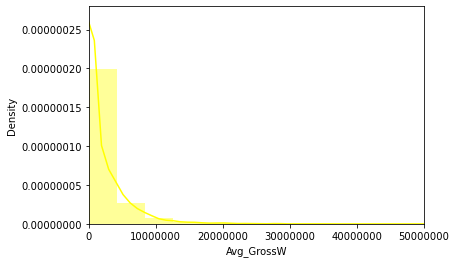

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(a=movie.Avg_GrossW, color='yellow') 
plt.ticklabel_format(style='plain') # to prevent scientific notatio n.
plt.xlim(xmin=0.0, xmax = 50000000)
plt.show()
